# Wines Points prediction 

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
46723,46723,US,"Highlighted by forward, pretty, cherry-candy f...",D2,91,40.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,DeLille 2009 D2 Red (Columbia Valley (WA)),Bordeaux-style Red Blend,DeLille
62816,62816,France,"A warm and rich wine, full of ripe black fruit...",NaN,87,NaN,Bordeaux,Cadillac Côtes de Bordeaux,NaN,Roger Voss,@vossroger,Château des Mille Anges 2010 Cadillac Côtes d...,Bordeaux-style Red Blend,Château des Mille Anges
120375,120375,Italy,"There's a grassy, dry element to the nose of t...",Costa d'Oro Brut,86,NaN,Veneto,Conegliano Valdobbiadene Prosecco Superiore,NaN,NaN,NaN,Scandolera NV Costa d'Oro Brut (Conegliano Va...,Glera,Scandolera
29028,29028,US,This great-value SB from Lake County hits it o...,NaN,87,10.0,California,Lake County,NaN,Virginie Boone,@vboone,Line 39 2010 Sauvignon Blanc (Lake County),Sauvignon Blanc,Line 39
93581,93581,Italy,"Spanish broom, acacia and nut aromas lead the ...",NaN,87,16.0,Northeastern Italy,Collio,NaN,Kerin O’Keefe,@kerinokeefe,Collavini 2015 Friulano (Collio),Friulano,Collavini


In [5]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [6]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

In [7]:
wine_reviews['desc_low'] = wine_reviews['description'].str.lower()
wine_reviews.sample()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_low
113490,US,This easy wine offers a rainbow of fruits—rasp...,7200 Range 30 West,86,40.0,California,Happy Canyon of Santa Barbara,Central Coast,NaN,NaN,Foxen 2010 7200 Range 30 West Merlot-Cabernet ...,Merlot-Cabernet Franc,Foxen,this easy wine offers a rainbow of fruits—rasp...


## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [8]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [9]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [12]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.622433
MAE    2.544336
R2    -0.000049
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [13]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.642756
Armenia                   87.500000
Australia                 88.549661
Austria                   90.111387
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [14]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.121303
MAE    2.471035
R2     0.052032
dtype: float64

#### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [15]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.759635
           Other               85.966427
Armenia    Armenia             87.500000
Australia  Australia Other     85.500000
           New South Wales     87.814286
Name: basiline_3_predicted_points, dtype: float64

In [16]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 17), (23998, 16))

In [17]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.552050
MAE    2.375740
R2     0.111194
dtype: float64

### Baselines summary

In [18]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.622433,2.544336,-0.000049
baseline_2,9.121303,2.471035,0.052032
baseline_3,8.552050,2.375740,0.111194


In [19]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [21]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [22]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [23]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [24]:
from src.models import i_feel_lucky_xgboost_training

In [25]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int64  
 1   province     95990 non-null  int64  
 2   region_1     95990 non-null  int64  
 3   region_2     95990 non-null  int64  
 4   taster_name  95990 non-null  int64  
 5   variety      95990 non-null  int64  
 6   winery       95990 non-null  int64  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 7.3 MB


In [26]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [27]:
test_encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,xgb_clf_points_prediction
2,41,269,1218,17,15,437,13018,14.0,87,87
5,38,263,758,6,12,591,14706,15.0,87,87
6,22,332,1205,6,9,186,15014,16.0,87,87
7,15,11,21,6,16,209,15395,24.0,87,88
8,17,308,738,6,1,209,8415,12.0,87,87


In [28]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.354821
MAE    1.910201
R2     0.339550
dtype: float64

In [29]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

,MSE,MAE,R2
baseline_1,9.622433,2.544336,-0.000049
baseline_2,9.121303,2.471035,0.052032
baseline_3,8.552050,2.375740,0.111194
regression_by_xgb,6.354821,1.910201,0.339550


In [30]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

### Data exploration

In [31]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charrlel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
stopwords=nltk.corpus.stopwords.words("english")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

#### Creating vocabulary from the Train set only:

In [33]:
all_words = [word for desc in train_data.desc_low for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,",",326100,3.890496e-07
1,.,261338,4.854597e-07
2,wine,59156,2.144652e-06
3,flavors,46519,2.727252e-06
4,'s,38298,3.312681e-06


In [34]:
words_df.shape

(41372, 3)

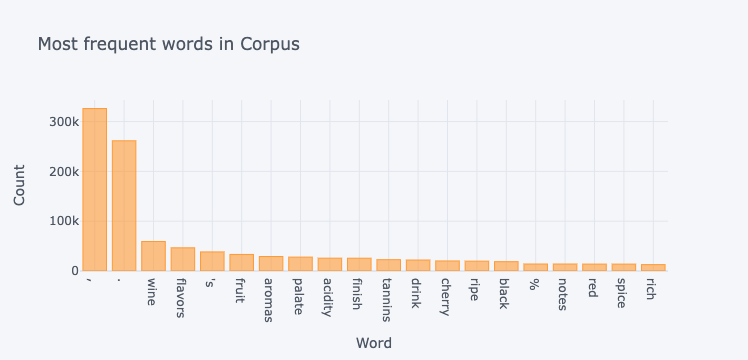

In [35]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [36]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 3047578 words, 41372 unique words


In [40]:
print ("Using words with 4 or more appearances will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 4)))

Using words with 4 or more appearances will reduce the corpus size to: 13993


In [41]:
words_df = words_df[words_df.wordCount >= 4]

#### Bag of words (One-hot-encoding) for Train

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
clean_vocab = set(words_df.word)

In [44]:
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)

In [50]:
clean_bow_counts_train = count_vect.fit_transform(train_data.desc_low)
clean_bow_counts_train

<95990x13993 sparse matrix of type '<class 'numpy.int64'>'
	with 2533347 stored elements in Compressed Sparse Row format>

In [51]:
clean_bow_counts_train.shape

(95990, 13993)

#### Bag of words (One-hot-encoding) for Test

In [52]:
clean_bow_counts_test = count_vect.fit_transform(test_data.desc_low)
clean_bow_counts_test

<23998x13993 sparse matrix of type '<class 'numpy.int64'>'
	with 631226 stored elements in Compressed Sparse Row format>

In [53]:
clean_bow_counts_test.shape

(23998, 13993)

### Regression (not Classification)

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error

In [55]:
from sklearn.linear_model import LinearRegression, Ridge

#### Search for the best alpha on the Train set only :

In [61]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, clean_bow_counts_train, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

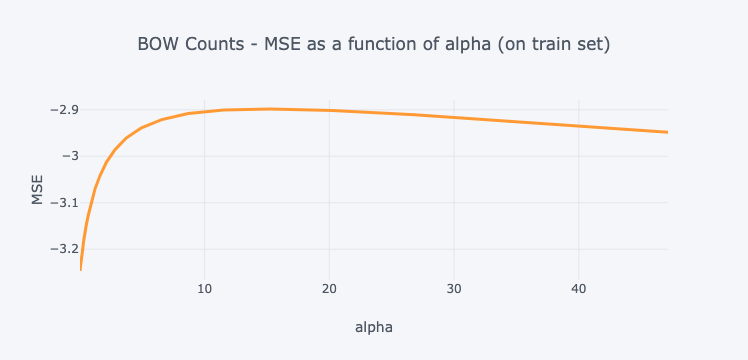

In [65]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [66]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

15.264179671752334 2.8982735230125676


#### Optimal Model : training the model with the best alpha, on the train set:

In [68]:

model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=15.264179671752334)

In [76]:
test_data['ridge_predicted_points'] = model.predict(clean_bow_counts_test)

In [79]:
ridge_stats = calc_prediction_quality(test_data, 'ridge_predicted_points','points')
ridge_stats

MSE    2.886120
MAE    1.340498
R2     0.700049
dtype: float64

In [80]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.622433,2.544336,-0.000049
baseline_2,9.121303,2.471035,0.052032
baseline_3,8.552050,2.375740,0.111194
regression_by_xgb,6.354821,1.910201,0.339550
ridge_stats,2.886120,1.340498,0.700049


### Using both the text and other features

#### Using both the text and other features (encoded in the Boosting trees part)

In [81]:
features

['country',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'variety',
 'winery',
 'price']

In [84]:
from scipy.sparse import coo_matrix, hstack

In [160]:
train_features_spares_matrix.shape

(95990, 9)

#### Search for the best alpha on the Train set only :

In [89]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

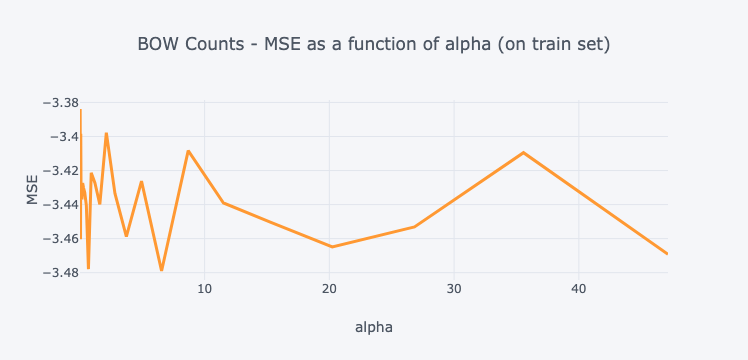

In [90]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [91]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

0.023299518105153717 3.3838477297303386


#### Optimal Model : training the model with the best alpha, on the train set:

In [92]:
#
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=0.023299518105153717)

In [93]:
test_data['ridge2_predicted_points'] = model.predict(clean_bow_counts_test)

In [94]:
ridge2_stats = calc_prediction_quality(test_data, 'ridge2_predicted_points','points')
ridge2_stats

MSE    3.127811
MAE    1.386229
R2     0.674930
dtype: float64

In [95]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.622433,2.544336,-0.000049
baseline_2,9.121303,2.471035,0.052032
baseline_3,8.552050,2.375740,0.111194
regression_by_xgb,6.354821,1.910201,0.339550
ridge_stats,2.886120,1.340498,0.700049
ridge2_stats,3.127811,1.386229,0.674930


#### Are there outliars in the encoded features ?

country           AxesSubplot(0.125,0.657941;0.227941x0.222059)
province       AxesSubplot(0.398529,0.657941;0.227941x0.222059)
region_1       AxesSubplot(0.672059,0.657941;0.227941x0.222059)
region_2          AxesSubplot(0.125,0.391471;0.227941x0.222059)
taster_name    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
variety        AxesSubplot(0.672059,0.391471;0.227941x0.222059)
winery               AxesSubplot(0.125,0.125;0.227941x0.222059)
price             AxesSubplot(0.398529,0.125;0.227941x0.222059)
points            AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

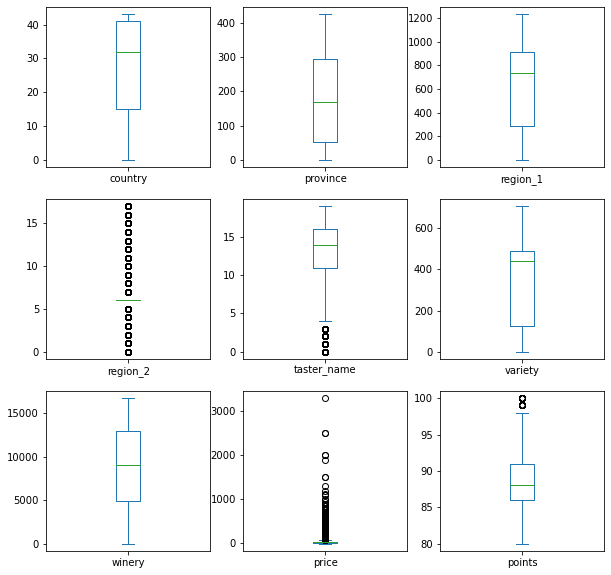

In [180]:
train_encoded_features.plot(kind='box', subplots=True, figsize=(10,10), layout=(3,3))

import numpy as np
from scipy import stats
train_encoded_features[(np.abs(stats.zscore(train_encoded_features)) < 3).all(axis=1)]


In [167]:
#removing the 'price' feature as it's showing a lot of outliars:
encoded_features2 = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features2['points'] = wine_reviews.points
encoded_features2.head()

,country,province,region_1,region_2,taster_name,variety,winery,points
0,22,332,424,6,9,691,11608,87
1,32,108,738,6,16,451,12956,87
2,41,269,1218,17,15,437,13018,87
3,41,218,549,6,0,480,14390,87
4,41,269,1218,17,15,441,14621,87


In [168]:
train_encoded_features2 = encoded_features2[encoded_features2.index.isin(train_data.index)]
test_encoded_features2 = encoded_features2[encoded_features2.index.isin(test_data.index)]
assert(len(train_encoded_features2) + len(test_encoded_features2) == len(wine_reviews))

In [169]:
train_features_spares_matrix2 = coo_matrix(train_encoded_features2)
train_united_features2 = hstack((clean_bow_counts_train ,train_features_spares_matrix2))

In [170]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features2, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

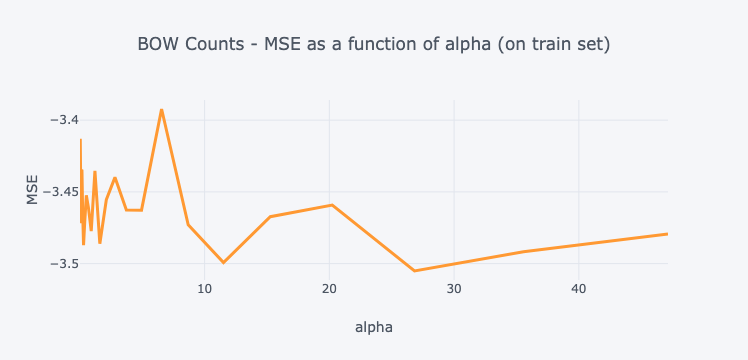

In [171]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [172]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

6.551285568595509 3.392231782016812


In [173]:
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=6.551285568595509)

In [174]:
test_data['ridge3_predicted_points'] = model.predict(clean_bow_counts_test)

In [175]:
ridge3_stats = calc_prediction_quality(test_data, 'ridge3_predicted_points','points')
ridge3_stats

MSE    2.905448
MAE    1.343747
R2     0.698040
dtype: float64

In [176]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats, ridge3_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats', 'ridge3_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.622433,2.544336,-0.000049
baseline_2,9.121303,2.471035,0.052032
baseline_3,8.552050,2.375740,0.111194
regression_by_xgb,6.354821,1.910201,0.339550
ridge_stats,2.886120,1.340498,0.700049
ridge2_stats,3.127811,1.386229,0.674930
ridge3_stats,2.905448,1.343747,0.698040


Removing the "price" feature improves the performance, but strangely it remains worse than the model that used the description only (BOW)

### 16.05.22 19h45 N-hot encoding

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

In [ ]:
#### Bag of words (One-hot-encoding) for Train

## Deep Learning approaches

### Fully connected network on the text only

1. Refaire le code
2. definir le voc vocab size
3. def la taille de la sequence (60) sequence length
4. text vectorization layer
5. std function, pas besoin de changer
6. train le reseau de neurones
7. play with nb of neurons, nb of dropouts
8. instead of averaging, do concatenation. Search in google sthg like "reshape"
9. comparison with Baselines, Trees, Classic NLP...



#### Tokenization

In [120]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [121]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [122]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [123]:
vectorize_layer.adapt(train_data['description'])

In [124]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

This dainty off-dry Riesling is marked by aromas—ripe stone fruit and florals against a backdrop of tea leaves and crushed minerals. On the palate, it's intensely juicy, with flavors of orange, mango and peach, but with a streak of acidity that ripples the tongue.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([   7, 2496,  538,  307,    8,  682,   32,    1,  216,   16,    2,
       2144,  607,    4, 1233,    5,  402,  717,    2,  236,  896,   15,
          3,   18,   14,  569,   71,    6,   10,    5,  132,  527,    2,
         80,   23,    6,    4,  510,    5,   20,   19, 8154,    3, 1124,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])>

In [125]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

7 --->  this
2496 --->  dainty
538 --->  offdry
307 --->  riesling
8 --->  is
682 --->  marked
32 --->  by
1 --->  [UNK]
216 --->  stone
16 --->  fruit
2 --->  and
2144 --->  florals
607 --->  against
4 --->  a
1233 --->  backdrop
5 --->  of
402 --->  tea
717 --->  leaves
2 --->  and
236 --->  crushed


#### Modeling

In [126]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [127]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout_2 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

In [128]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [129]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [130]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 10s 13ms/step - loss: 22.0743 - mean_squared_error: 1366.3499 - mean_absolute_error: 22.0743 - val_loss: 2.4931 - val_mean_squared_error: 9.3404 - val_mean_absolute_error: 2.4931
Epoch 2/20
750/750 [==============================] - 12s 17ms/step - loss: 3.4662 - mean_squared_error: 18.8713 - mean_absolute_error: 3.4662 - val_loss: 1.7205 - val_mean_squared_error: 4.6429 - val_mean_absolute_error: 1.7205
Epoch 3/20
750/750 [==============================] - 10s 14ms/step - loss: 3.1929 - mean_squared_error: 16.0531 - mean_absolute_error: 3.1929 - val_loss: 1.5160 - val_mean_squared_error: 3.6617 - val_mean_absolute_error: 1.5160
Epoch 4/20
750/750 [==============================] - 10s 13ms/step - loss: 3.0960 - mean_squared_error: 15.0675 - mean_absolute_error: 3.0960 - val_loss: 1.4510 - val_mean_squared_error: 3.3679 - val_mean_absolute_error: 1.4510
Epoch 5/20
750/750 [==============================] - 11s 14ms/step - loss: 3.09

### Simple NN Prediction & Evaluation

In [131]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [132]:
dnn_stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
dnn_stats

MSE    2.931321
MAE    1.351606
R2     0.695351
dtype: float64

In [133]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats, dnn_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats', 'dnn_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.622433,2.544336,-0.000049
baseline_2,9.121303,2.471035,0.052032
baseline_3,8.552050,2.375740,0.111194
regression_by_xgb,6.354821,1.910201,0.339550
ridge_stats,2.886120,1.340498,0.700049
ridge2_stats,3.127811,1.386229,0.674930
dnn_prediction,2.931321,1.351606,0.695351


### Descriptions words concatinated

In [135]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

In [136]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [137]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [138]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [139]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 15s 19ms/step - loss: 24.5388 - mean_squared_error: 1125.7474 - mean_absolute_error: 24.5388 - val_loss: 2.6457 - val_mean_squared_error: 10.7641 - val_mean_absolute_error: 2.6457
Epoch 2/20
750/750 [==============================] - 14s 18ms/step - loss: 8.6754 - mean_squared_error: 117.7805 - mean_absolute_error: 8.6754 - val_loss: 2.6980 - val_mean_squared_error: 11.4141 - val_mean_absolute_error: 2.6980
Epoch 3/20
750/750 [==============================] - 13s 17ms/step - loss: 8.6865 - mean_squared_error: 118.3228 - mean_absolute_error: 8.6865 - val_loss: 2.6403 - val_mean_squared_error: 10.7087 - val_mean_absolute_error: 2.6403
Epoch 4/20
750/750 [==============================] - 14s 18ms/step - loss: 8.6637 - mean_squared_error: 117.7916 - mean_absolute_error: 8.6637 - val_loss: 2.6748 - val_mean_squared_error: 11.1133 - val_mean_absolute_error: 2.6748
Epoch 5/20
750/750 [==============================] - 12s 17ms/step - los

In [140]:
test_data['dnn2_prediction'] = model.predict(test_data[text_col])

In [141]:
dnn2_stats = calc_prediction_quality(test_data, 'dnn2_prediction', target_col)
dnn2_stats

MSE    4.181462
MAE    1.618743
R2     0.565425
dtype: float64

In [142]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, ridge_stats, ridge2_stats, dnn_stats, dnn2_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb', 'ridge_stats', 'ridge2_stats', 'dnn_prediction', 'dnn2_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.622433,2.544336,-0.000049
baseline_2,9.121303,2.471035,0.052032
baseline_3,8.552050,2.375740,0.111194
regression_by_xgb,6.354821,1.910201,0.339550
ridge_stats,2.886120,1.340498,0.700049
ridge2_stats,3.127811,1.386229,0.674930
dnn_prediction,2.931321,1.351606,0.695351
dnn2_prediction,4.181462,1.618743,0.565425


In [144]:
# pourquoi les scores ne matchent pas avec la video
# pourquoi c'est pas ecrit en haut python 3.9 alors que je l'ai installé ? où l'activer? 

In [145]:
#final project : faire par nous même external embeddings, plus encore une/des autre approche (RNN, LSTM)